In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report

In [ ]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
#Mount on drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/UMN_CS_PhD/RA/Datasets for JOUR8500/GroundTruth/

/content/gdrive/MyDrive/UMN_CS_PhD/RA/Datasets for JOUR8500/GroundTruth


In [ ]:
%pwd

'/content/gdrive/MyDrive/UMN_CS_PhD/RA/Datasets for JOUR8500/GroundTruth'

In [ ]:
#Read original gold_silver dataset first
gold = pd.read_csv("/content/input_gold_silver_labels.csv", header=0)
gold.head()

,user_id,description,truncated,created_at,full_text_concatenated,ideology
0,347580883,NaN,False,Mon Dec 27 19:25:17 +0000 2021,@Louis_Tomlinson happy 30th king 🥳|@Louis_Toml...,1
1,617547972,NaN,False,Mon Dec 27 19:25:17 +0000 2021,@evilentity_ hurts !!!|@n0ctowl just demo! pre...,0
2,196867688,NaN,False,Mon Dec 27 19:25:17 +0000 2021,You can get free gift cards for discovering th...,1
3,1564877802,Debt free pianist and cat person,False,Mon Dec 27 19:25:17 +0000 2021,New piece 🤗 Delving into the classical period ...,0
4,27956258,NaN,False,Mon Dec 27 19:25:17 +0000 2021,Hello @Scott_Fontana|RT @Scott_Fontana: Belate...,0


In [ ]:
#Read in the user_history
user_history_path = "most_pol_user_history_1.csv"
user_history = pd.read_csv(user_history_path, header=0)
user_history.head()

,user_id,user_history
0,564150644,"RT @McFaul: In the long run, Trump's policy to..."
1,564210319,@RepCawthorn Listen to you kowtowing to the Qu...
2,564272875,RT @JuddLegum: New anti-CRT bill in New Hampsh...
3,56428877,"Contrary to popular belief, more money doesn't..."
4,564328187,@tonyhawk Fayetteville NC coulda used that mon...


In [ ]:
#Join based on user id to form the full new training dataset
print ("Gold -", gold.shape)
print ("User History -", user_history.shape)
df = pd.merge(gold, user_history, how='inner', on='user_id')

Gold - (10762, 6)
User History - (10762, 2)


In [ ]:
df.shape

(10762, 7)

In [ ]:
df.head()

,user_id,description,truncated,created_at,full_text_concatenated,ideology,user_history
0,347580883,NaN,False,Mon Dec 27 19:25:17 +0000 2021,@Louis_Tomlinson happy 30th king 🥳|@Louis_Toml...,1,RT @nbc6: Joe Biden’s national lead over Presi...
1,617547972,NaN,False,Mon Dec 27 19:25:17 +0000 2021,@evilentity_ hurts !!!|@n0ctowl just demo! pre...,0,RT @CoryTownes: Nah. RT @illroots: FALSE ALARM...
2,196867688,NaN,False,Mon Dec 27 19:25:17 +0000 2021,You can get free gift cards for discovering th...,1,Getting my sawmill ep 3 roblox lumber tycoon 2...
3,1564877802,Debt free pianist and cat person,False,Mon Dec 27 19:25:17 +0000 2021,New piece 🤗 Delving into the classical period ...,0,"And when the shades of evening fall, | Or ..."
4,27956258,NaN,False,Mon Dec 27 19:25:17 +0000 2021,Hello @Scott_Fontana|RT @Scott_Fontana: Belate...,0,I'm off next weekend. I don't even know what t...


### Filter out user descriptions that dont exist and join the histort and description columns ###


In [ ]:
df_new = df[~df['description'].isnull()]
df_new['ideology'].value_counts()

1    5361
0    3187
Name: ideology, dtype: int64

In [ ]:
df = df_new
# concatenate columns together
df['user_context'] = df['description']+df['user_history']
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,description,truncated,created_at,full_text_concatenated,ideology,user_history,user_context
3,1564877802,Debt free pianist and cat person,False,Mon Dec 27 19:25:17 +0000 2021,New piece 🤗 Delving into the classical period ...,0,"And when the shades of evening fall, | Or ...",Debt free pianist and cat personAnd when the s...
5,574871459,"Just a Philly gay who loves music, food and mo...",False,Mon Dec 27 19:25:17 +0000 2021,THIS IS GONNA BE SO AWESOME!!! One of my favor...,1,@theoh_c Still waiting patiently for your Only...,"Just a Philly gay who loves music, food and mo..."
6,1711251450,She/Her. Writer / Artist / Gamer / Mom / Prof...,False,Mon Dec 27 19:25:17 +0000 2021,"RT @CREWcrew: No, Speaker Pelosi, members of C...",1,"RT @chimeracoder: Once again, Democrats watere...",She/Her. Writer / Artist / Gamer / Mom / Prof...
7,14222204,reader. hockey fanatic. writer. student. plann...,False,Mon Dec 27 19:25:17 +0000 2021,@letsread Works now! Thanks!|@letsread I'm get...,1,---|---|---|---|---|Trying to finish Assassin'...,reader. hockey fanatic. writer. student. plann...
9,1165062295,Author of My Authentic Soul. Love Pittsburgh S...,False,Mon Dec 27 19:25:17 +0000 2021,@RenegadeAdam Happy Birthday!|RT @crliss21: No...,1,RETWEET &amp; reply with “#WPMOYChallenge Heyw...,Author of My Authentic Soul. Love Pittsburgh S...


In [ ]:
df.shape

(8548, 8)

### Balancing class representation ###

In [ ]:

df_lib = df[df['ideology']==1]
df_lib.shape

(5361, 8)

In [ ]:
df_cons = df[df['ideology']==0]
df_cons.shape

(3187, 8)

In [ ]:
df_lib_downsampled = df_lib.sample(df_cons.shape[0])
df_lib_downsampled.shape

(3187, 8)

In [ ]:
df_balanced = pd.concat([df_lib_downsampled, df_cons])
df_balanced.shape

(6374, 8)

In [ ]:
df_balanced['ideology'].value_counts()

1    3187
0    3187
Name: ideology, dtype: int64

###Split into train and test ###

In [ ]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(df_balanced['desc_clean'],df_balanced['ideology'], stratify=df_balanced['ideology'])
#run when no balancing is done
X_train, X_test, y_train, y_test = train_test_split(df['user_context'],df['ideology'], stratify=df['ideology'])

In [ ]:
print("train", X_train.shape)
print("test", X_test.shape)

train (6411,)
test (2137,)


In [ ]:
y_train.value_counts()

1    4021
0    2390
Name: ideology, dtype: int64

In [ ]:
y_test.value_counts()

1    1340
0     797
Name: ideology, dtype: int64

### Training Process ###

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
#l = tf.keras.layers.Dropout(1.0, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#history = model.fit(X_train, y_train, validation_split = 0.1, epochs=100, batch_size=32)
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=500, batch_size=32, callbacks=callbacks_list)

Epoch 1/500
181/181 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6479 - precision: 0.6579 - recall: 0.9090
Epoch 1: val_accuracy improved from -inf to 0.65421, saving model to weights.best.hdf5
181/181 [==============================] - 70s 385ms/step - loss: 0.6287 - accuracy: 0.6479 - precision: 0.6579 - recall: 0.9090 - val_loss: 0.6168 - val_accuracy: 0.6542 - val_precision: 0.6672 - val_recall: 0.9354
Epoch 2/500
181/181 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6512 - precision: 0.6599 - recall: 0.9112
Epoch 2: val_accuracy did not improve from 0.65421
181/181 [==============================] - 68s 376ms/step - loss: 0.6274 - accuracy: 0.6512 - precision: 0.6599 - recall: 0.9112 - val_loss: 0.6176 - val_accuracy: 0.6480 - val_precision: 0.6638 - val_recall: 0.9306
Epoch 3/500
181/181 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6478 - precision: 0.6603 - recall: 0.8979
Epoch 3: val_accuracy did no

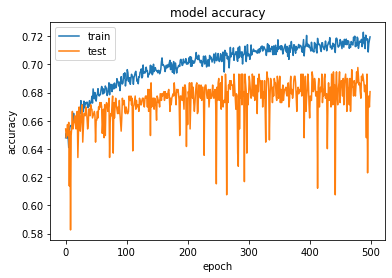

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

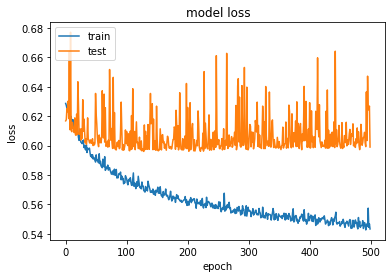

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("usercontext_weights.h5")

### Load model for evaluation ###

In [ ]:
import keras

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#Create the older model
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
load_model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
#load weights
weights_path = "/content/gdrive/MyDrive/UMN_CS_PhD/RA/Datasets for JOUR8500/GroundTruth/usercontext_weights.h5"
load_model.load_weights(weights_path)

In [ ]:
from sklearn.metrics import classification_report

y_predicted = load_model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_orig = y_test.to_numpy()
print(classification_report(y_orig, y_predicted))

67/67 [==============================] - 22s 283ms/step
              precision    recall  f1-score   support

           0       0.63      0.39      0.48       797
           1       0.70      0.86      0.77      1340

    accuracy                           0.68      2137
   macro avg       0.66      0.62      0.63      2137
weighted avg       0.67      0.68      0.66      2137

